<a href="https://colab.research.google.com/github/MonicaSai7/OCR-using-CRNN/blob/master/CRNN_HDF5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Libraries

In [2]:
import os
import string
import cv2
import h5py
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Lambda, Bidirectional, LSTM, Dense

In [ ]:
!pip install keract

# Data Acquisition

In [ ]:
with h5py.File("/content/drive/My Drive/mjsynth_1000000.hdf5", 'r') as f:
    training_img = f.get('train_img').value
    orig_txt = f.get('train_labels').value
    valid_img = f.get('valid_img').value
    valid_orig_txt = f.get('valid_labels').value
f.close()

In [ ]:
type(training_img[0])

In [ ]:
char_list = string.ascii_letters + string.digits
print(char_list)
print(len(char_list))

In [ ]:
def encode_to_labels(text):
    code = []
    for index, char in enumerate(text):
        code.append(char_list.index(char))
    return code

In [ ]:
length_checker = np.vectorize(len) 
max_train_label_len = max(length_checker(orig_txt))
max_test_label_len = max(length_checker(valid_orig_txt))
max_label_len = max(max_train_label_len, max_test_label_len)

In [ ]:
train_label_length = []
train_input_length = []
training_txt = []

for i in range(len(orig_txt)):
    train_label_length.append(len(orig_txt[i]))
    train_input_length.append(31)
    training_txt.append(encode_to_labels(orig_txt[i]))

In [ ]:
valid_label_length = []
valid_input_length = []
valid_txt = []

for i in range(len(valid_orig_txt)):
    valid_label_length.append(len(orig_txt[i]))
    valid_input_length.append(31)
    valid_txt.append(encode_to_labels(valid_orig_txt[i]))

In [ ]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

# Model Architecture

### Model = CNN + RNN + CTC loss

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
 
act_model = Model(inputs, outputs)

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
type(labels)

tensorflow.python.framework.ops.Tensor

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

batch_size = 256
epochs = 10
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, 
                              valid_label_length], [np.zeros(len(valid_img))]), 
          verbose = 1, callbacks = callbacks_list)

Epoch 1/10
528/528 [==============================] - ETA: 0s - loss: 26.6351 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 21.41273, saving model to best_model.hdf5
528/528 [==============================] - 313s 592ms/step - loss: 26.6351 - accuracy: 0.0000e+00 - val_loss: 21.4127 - val_accuracy: 0.0000e+00
Epoch 2/10
528/528 [==============================] - ETA: 0s - loss: 16.7057 - accuracy: 0.0044
Epoch 00002: val_loss improved from 21.41273 to 13.48270, saving model to best_model.hdf5
528/528 [==============================] - 303s 573ms/step - loss: 16.7057 - accuracy: 0.0044 - val_loss: 13.4827 - val_accuracy: 0.0066
Epoch 3/10
528/528 [==============================] - ETA: 0s - loss: 5.3948 - accuracy: 0.2473
Epoch 00003: val_loss improved from 13.48270 to 11.53374, saving model to best_model.hdf5
528/528 [==============================] - 303s 573ms/step - loss: 5.3948 - accuracy: 0.2473 - val_loss: 11.5337 - val_accuracy: 0.2581
Epoch 4/10
528/528 [===

In [ ]:
model.save_weights("model.hdf5")

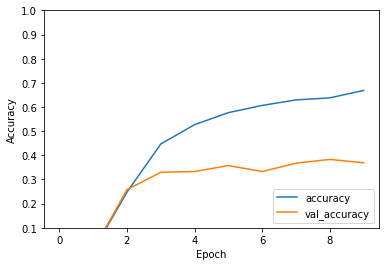

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
scores = model.evaluate([training_img, train_padded_txt, train_input_length, train_label_length], np.zeros(len(training_img)), verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

4219/4219 [==============================] - 288s 68ms/step - loss: 1.8106 - accuracy: 0.6677
accuracy: 66.77%
